In [2]:
pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixak-Uxnajidah9RCAkEF0QuDtMqyEYuB1GQWLYt0fPAaxVhzTM1nvZviB10oeG5khmbqHO9tyGEfYRxjBH9w'
)
nixtla_client.validate_api_key()


True

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

# Set up parameters
start_date = '1945-01-01'
n_months = 120  # Number of months to generate
amplitude = 1
angular_frequency = 2 * np.pi / 36  # A full sine wave cycle every 12 months

# Generate the timestamps
dates = [pd.Timestamp(start_date) + DateOffset(months=i) for i in range(n_months)]

# Generate the sine values
values = amplitude * np.sin(np.arange(n_months) * angular_frequency)

# Create the DataFrame
df = pd.DataFrame({
    'timestamp': dates,
    'value': values
})

# Show the DataFrame
print(df)


     timestamp     value
0   1945-01-01  0.000000
1   1945-02-01  0.173648
2   1945-03-01  0.342020
3   1945-04-01  0.500000
4   1945-05-01  0.642788
..         ...       ...
115 1954-08-01  0.939693
116 1954-09-01  0.984808
117 1954-10-01  1.000000
118 1954-11-01  0.984808
119 1954-12-01  0.939693

[120 rows x 2 columns]


In [70]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

# Set up parameters
start_date = '1945-01-01'
n_months = 120  # Number of months to generate
amplitude = 1
angular_frequency = 2 * np.pi / 36  # A full sine wave cycle every 12 months
linear_slope = 0.05  # Linear growth rate per month

# Generate the timestamps
dates = [pd.Timestamp(start_date) + DateOffset(months=i) for i in range(n_months)]

# Generate the combined values: linear + sine
months_passed = np.arange(n_months)
linear_values = linear_slope * months_passed
sine_values = amplitude * np.sin(months_passed * angular_frequency)
combined_values = linear_values + sine_values

# Create the DataFrame
df = pd.DataFrame({
    'timestamp': dates,
    'value': combined_values
})

# Show the DataFrame
print(df)


     timestamp     value
0   1945-01-01  0.000000
1   1945-02-01  0.223648
2   1945-03-01  0.442020
3   1945-04-01  0.650000
4   1945-05-01  0.842788
..         ...       ...
115 1954-08-01  6.689693
116 1954-09-01  6.784808
117 1954-10-01  6.850000
118 1954-11-01  6.884808
119 1954-12-01  6.889693

[120 rows x 2 columns]


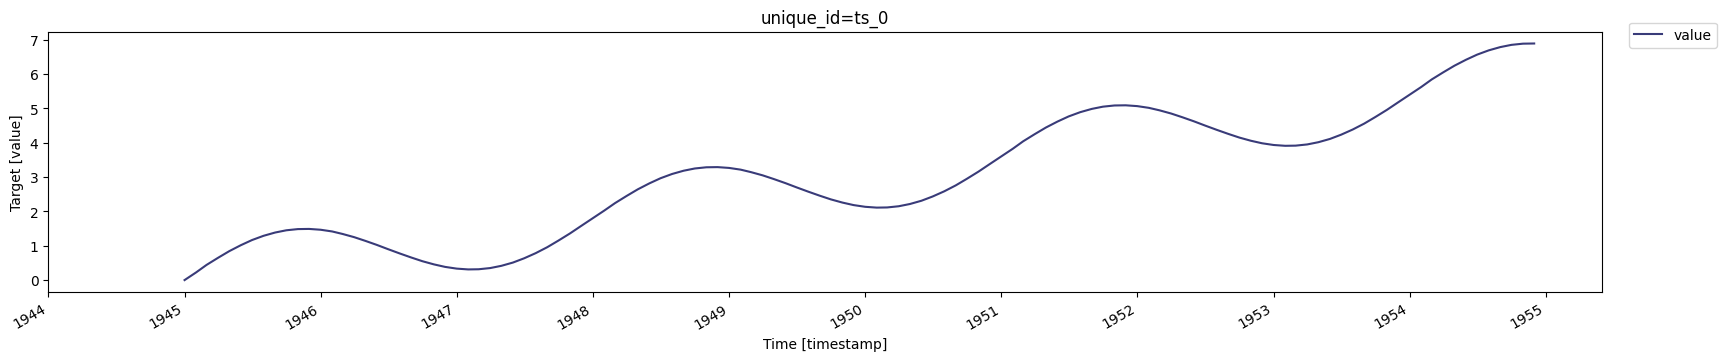

In [71]:
nixtla_client.plot(df, time_col='timestamp', target_col='value')


In [72]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=36, finetune_steps=100, freq='MS', time_col='timestamp', target_col='value')
timegpt_fcst_df.head()


,timestamp,TimeGPT
0,1955-01-01,6.806752
1,1955-02-01,6.763944
2,1955-03-01,6.657406
3,1955-04-01,6.550116
4,1955-05-01,6.384476


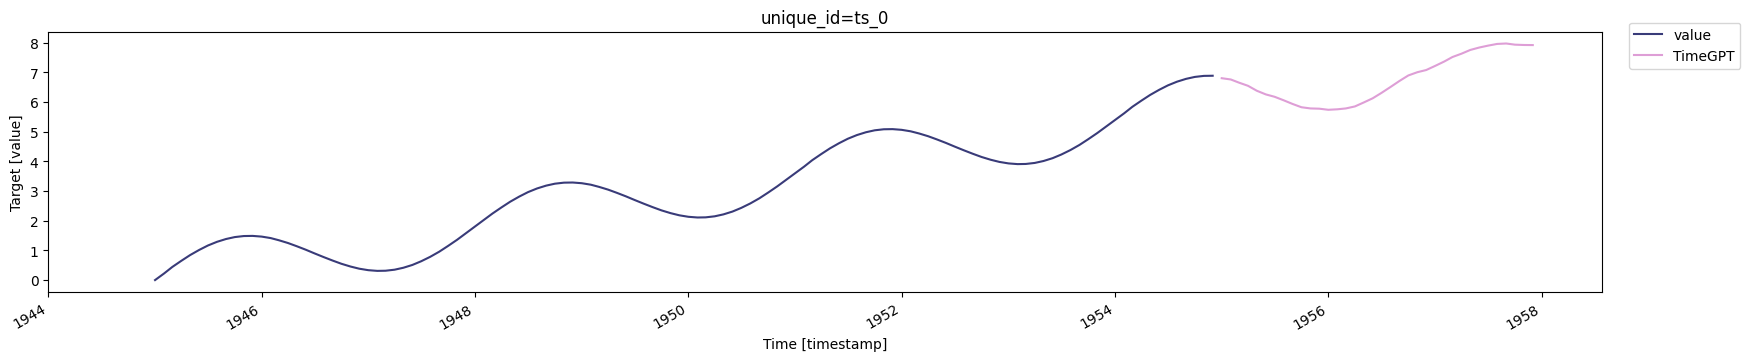

In [73]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random


In [28]:
def generate(list_of_params, m, C=512, L=96):
    x = []
    y = []

    for (A, T, S) in list_of_params:
        for _ in range(m):
            # Random phase shift in [0, T)
            phase_shift = np.random.uniform(0, T)
            # Generate total data points
            total_months = C + L
            months_passed = np.arange(total_months) + phase_shift
            # Calculate sine values
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            # Calculate linear trend
            linear_values = S * months_passed
            # Combine sine and linear trend
            values = sine_values + linear_values
            # Split into input and output
            x.append(values[:C])
            y.append(values[C:C+L])

    x = np.array(x)
    y = np.array(y)
    return x, y

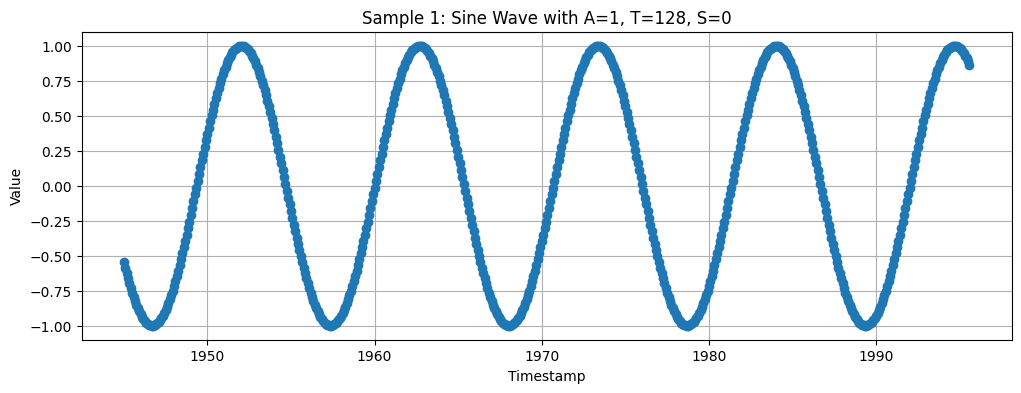

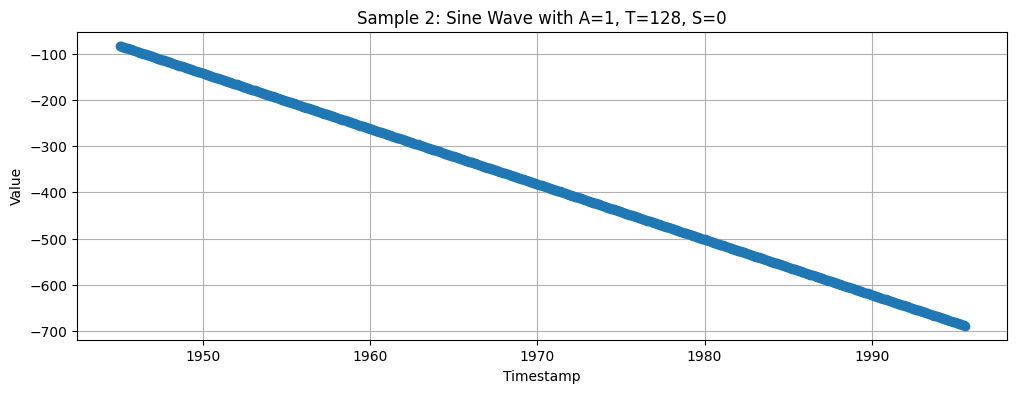

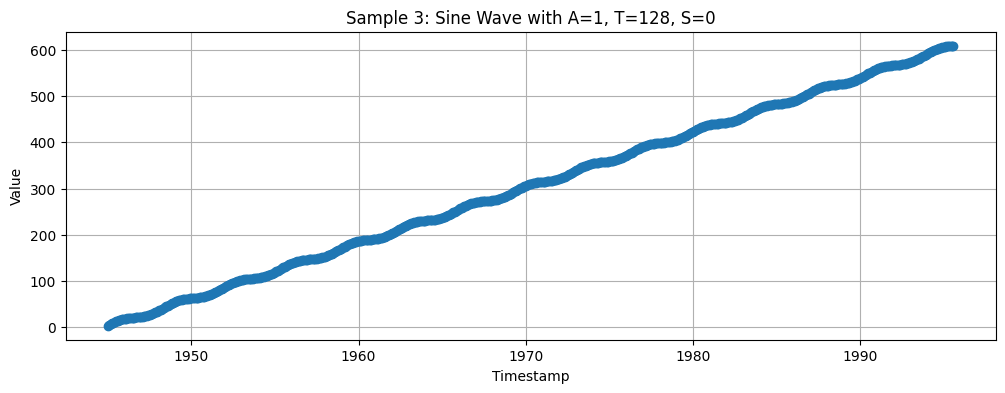

In [29]:
def plot_samples(x, y, list_of_params, m, num_samples=3):
    total_months = x.shape[1] + y.shape[1]
    start_date = pd.Timestamp('1945-01-01')

    for i in range(num_samples):
        # Identify which (A, T, S) tuple this sample belongs to
        param_index = i // m
        A, T, S = list_of_params[param_index]
        
        # Combine input and output
        full_series = np.concatenate([x[i], y[i]])
        # Create timestamps
        dates = [start_date + DateOffset(months=j) for j in range(total_months)]
        # Create DataFrame for plotting
        df = pd.DataFrame({
            'timestamp': dates,
            'value': full_series
        })
        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(df['timestamp'], df['value'], marker='o')
        plt.title(f"Sample {i+1}: Sine Wave with A={A}, T={T}, S={S}")
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()
        
params = [(1, 128, 0), (0, 128, -1), (5, 42, 1)]
x, y = generate(params, 1)
plot_samples(x, y, params, 5)

In [66]:
def convert_to_df(x, is_input=True, start_date='1945-01-01', L=96):
    if is_input:
        base_date = pd.Timestamp(start_date)
    else:
        # Offset by L months for outputs
        base_date = pd.Timestamp(start_date) + DateOffset(months=L)

    n = len(x)
    dates = [base_date + DateOffset(months=i) for i in range(n)]
    if is_input:
        df = pd.DataFrame({
            'timestamp': dates,
            'value': x
        })
    else:
        df = pd.DataFrame({
            'timestamp': dates,
            'TimeGPT': x
        })
    return df

def convert_to_array(df):
    return df['TimeGPT'].values

In [31]:
class TimeSeriesModel(nn.Module):
    def __init__(self, C, L):
        super(TimeSeriesModel, self).__init__()
        self.C = C
        self.L = L
        # Define the linear head
        self.linear_head = nn.Sequential(
            nn.Linear(L, 64),
            nn.ReLU(),
            nn.Linear(64, L)
        )

    def forward(self, x):
        device = x.device
        refined = self.linear_head(x)
        return refined

def precompute_forecasts(x, L = 96):
    forecasts = []
    for i in range(x.shape[0]):
        input_array = x[i]
        df_input = convert_to_df(input_array, is_input=True, start_date='1945-01-01', L=L)
        
        # Forecast using TimeGpt
        forecast_df = nixtla_client.forecast(
            df=df_input,
            h=L,
            freq='MS',
            time_col='timestamp',
            target_col='value'
        )

        # Convert forecast dataframe back to a NumPy array
        forecast_values = convert_to_array(forecast_df)
        forecasts.append(forecast_values)

    return np.array(forecasts)

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [40]:
def train_model(x, y, list_of_params, C = 512, L = 96, num_epochs=20, learning_rate=0.001):
    # Pre-compute forecasts for all x values
    print("\nLoading TimeGPT...")
    precomputed_forecasts = precompute_forecasts(x, L)

    # Create a new dataset with the pre-computed forecasts
    dataset = TimeSeriesDataset(precomputed_forecasts, y)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize the model
    model = TimeSeriesModel(C=C, L=L)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Train the entire model

    # Training loop
    print("\nStarting Training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            # Convert numpy arrays to torch tensors
            batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)  # Shape: (batch_size, L)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)  # Shape: (batch_size, L)

            optimizer.zero_grad()
            outputs = model(batch_x)  # Shape: (batch_size, L)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_x.size(0)

        epoch_loss /= len(dataset)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')

    print("\nTraining Completed.")
    
    return model

In [75]:
def display_plot(model, list_of_params, C = 512, L = 96):
    model.eval()
    device = next(model.parameters()).device
    print("Displaying Plot")
    with torch.no_grad():
        A, T, S = random.choice(list_of_params)
        # Random phase shift
        phase_shift = np.random.uniform(0, T)
        # Generate input data
        months_passed = np.arange(C + L) + phase_shift
        sine_values = A * np.sin(2 * np.pi / T * months_passed)
        linear_values = S * months_passed
        values = sine_values + linear_values

        # Separate x and y
        x = values[:C]
        y_actual = values[C:C + L]

        # Convert to DataFrame for forecasting
        df_input = convert_to_df(x, is_input=True, start_date='1945-01-01', L=L)
        # Forecast using TimeGpt
        forecast_df = nixtla_client.forecast(
            df=df_input,
            h=L,
            freq='MS',
            time_col='timestamp',
            target_col='value'
        )
        forecast_values = convert_to_array(forecast_df)

        # Convert forecast to tensor and pass through linear head
        forecast_tensor = torch.tensor(forecast_values, dtype=torch.float32).to(device).unsqueeze(0)  # Shape: (1, L)
        y_pred = model.linear_head(forecast_tensor).squeeze(0).cpu().numpy() 
        df_output = convert_to_df(y_pred, is_input = False, start_date='1945-01-01', L=C)
        return df_input, df_output

In [35]:
def evaluate_model(model, list_of_params, C=512, L=96, num_evaluations=100):
    
    model.eval()
    mse_loss = nn.MSELoss()
    total_mse = 0.0
    
    device = next(model.parameters()).device

    print("\nStarting Evaluation...")
    with torch.no_grad():
        for _ in range(num_evaluations):
            # Randomly select a parameter
            A, T, S = random.choice(list_of_params)
            # Random phase shift
            phase_shift = np.random.uniform(0, T)
            # Generate input data
            months_passed = np.arange(C + L) + phase_shift
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            linear_values = S * months_passed
            values = sine_values + linear_values
            
            # Separate x and y
            x = values[:C]
            y_actual = values[C:C + L]

            # Convert to DataFrame for forecasting
            df_input = convert_to_df(x, is_input=True, start_date='1945-01-01', L=L)
            # Forecast using TimeGpt
            forecast_df = nixtla_client.forecast(
                df=df_input,
                h=L,
                freq='MS',
                time_col='timestamp',
                target_col='value'
            )
            forecast_values = convert_to_array(forecast_df)

            # Convert forecast to tensor and pass through linear head
            forecast_tensor = torch.tensor(forecast_values, dtype=torch.float32).to(device).unsqueeze(0)  # Shape: (1, L)
            y_pred = model.linear_head(forecast_tensor).squeeze(0).cpu().numpy()  # Shape: (L,)

            # Compute MSE for this sample
            mse = mse_loss(torch.tensor(y_actual, dtype=torch.float32), torch.tensor(y_pred, dtype=torch.float32))
            total_mse += mse.item()

    average_mse = total_mse / num_evaluations
    return average_mse


Generated Parameters (A, T, S):
Param 1: A=1, T=250, S=0
Param 2: A=1, T=454, S=0
Param 3: A=1, T=498, S=0
Param 4: A=1, T=129, S=0
Param 5: A=1, T=393, S=0

Generated data: x shape = (100, 512), y shape = (100, 96)


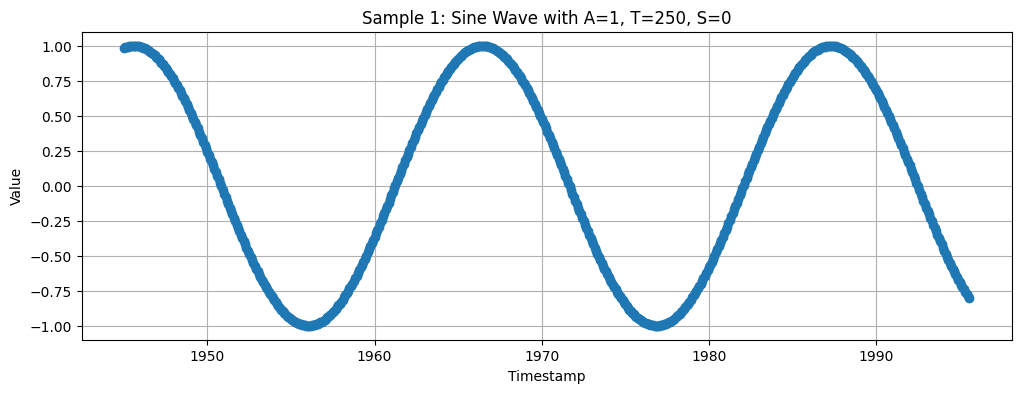

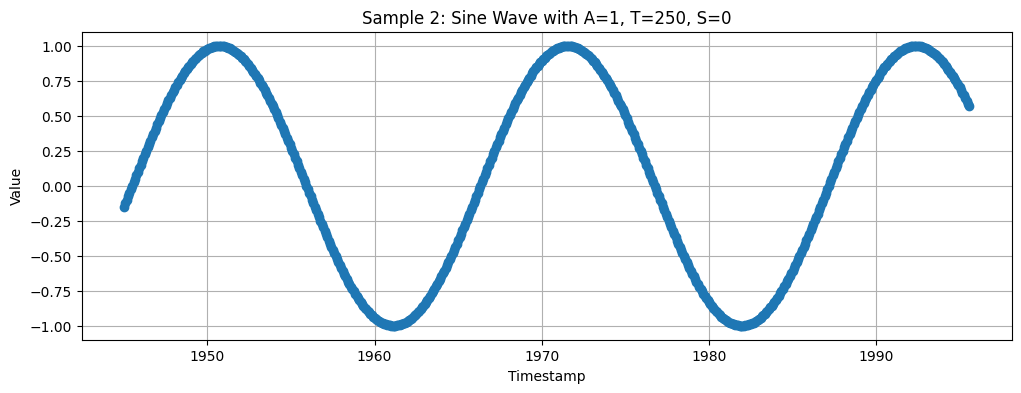

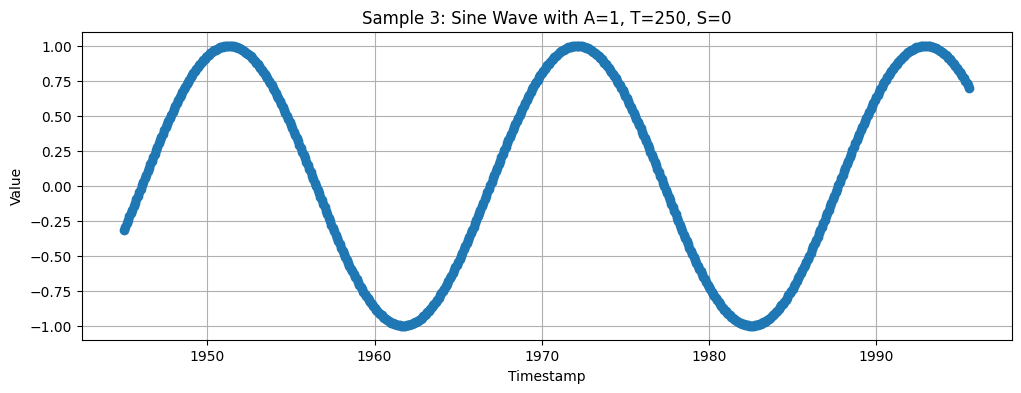

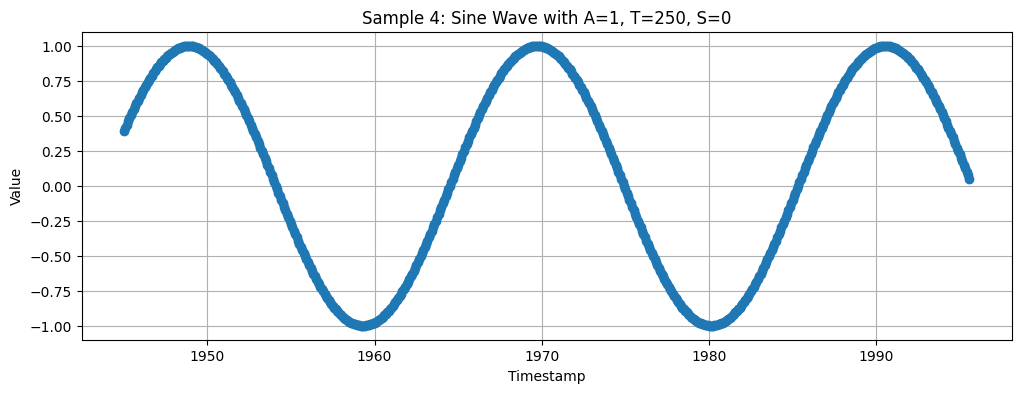

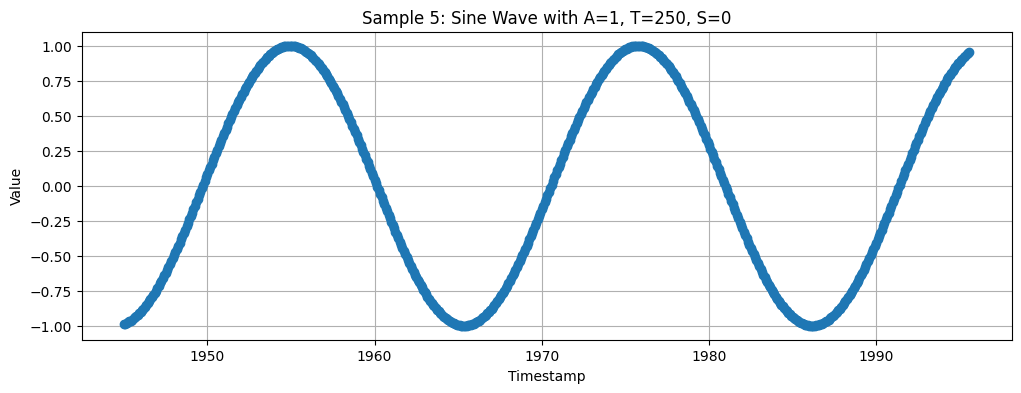


Loading TimeGPT...

Starting Training...
Epoch 1/20, Loss: 0.476558
Epoch 5/20, Loss: 0.305550
Epoch 10/20, Loss: 0.290737
Epoch 15/20, Loss: 0.277770


/tmp/ipykernel_30/325816468.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)  # Shape: (batch_size, L)
/tmp/ipykernel_30/325816468.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)  # Shape: (batch_size, L)


Epoch 20/20, Loss: 0.265991

Training Completed.

Starting Evaluation...
Average MSE over 100 evaluations: 0.287703
Displaying Plot


In [76]:
def run():
    # Parameters
    num_params = 5
    m = 20  # Number of instances per (A, T, S) tuple
    C = 512  # Number of input months
    L = 96  # Number of output months
    start_date = '1945-01-01'
    learning_rate = 1e-3
    num_epochs = 50

    # 1. Generate a random list of 5 params with A=1, S=0, T random between 12 and 36
    list_of_params = []
    for _ in range(num_params):
        A = 1
        S = 0
        T = random.randint(64, 512)
        list_of_params.append((A, T, S))
    print("Generated Parameters (A, T, S):")
    for idx, param in enumerate(list_of_params):
        print(f"Param {idx+1}: A={param[0]}, T={param[1]}, S={param[2]}")

    # 2. Generate 20 instances of each function
    x, y = generate(list_of_params=list_of_params, m=m, C=C, L=L)
    print(f"\nGenerated data: x shape = {x.shape}, y shape = {y.shape}")

    # Optional: Plot a few samples to ensure it's working
    plot_samples(x, y, list_of_params, m, num_samples=5)

    model = train_model(x, y, list_of_params)
    average_mse = evaluate_model(model, list_of_params, C=C, L=L, num_evaluations=100)
    print(f'Average MSE over 100 evaluations: {average_mse:.6f}')
    return display_plot(model, list_of_params)

x, y = run()

In [77]:
print(x)

     timestamp     value
0   1945-01-01 -0.871357
1   1945-02-01 -0.883412
2   1945-03-01 -0.894909
3   1945-04-01 -0.905840
4   1945-05-01 -0.916200
..         ...       ...
507 1987-04-01 -0.943782
508 1987-05-01 -0.951791
509 1987-06-01 -0.959199
510 1987-07-01 -0.966001
511 1987-08-01 -0.972193

[512 rows x 2 columns]


In [78]:
print(y)

    timestamp   TimeGPT
0  1987-09-01 -1.035287
1  1987-10-01 -1.009192
2  1987-11-01 -0.962940
3  1987-12-01 -1.053022
4  1988-01-01 -1.004592
..        ...       ...
91 1995-04-01  0.051837
92 1995-05-01  0.009340
93 1995-06-01 -0.021829
94 1995-07-01  0.018712
95 1995-08-01  0.066102

[96 rows x 2 columns]


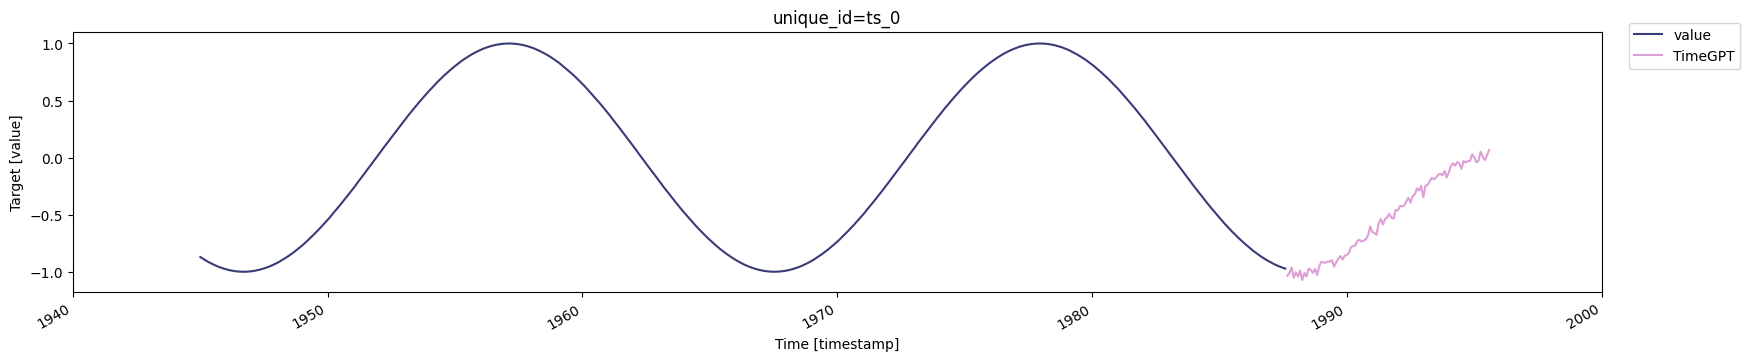

In [80]:
nixtla_client.plot(x, y, time_col='timestamp', target_col='value')
